In [2]:
#@title
# !kill -9 -1
! pip install pydrive

# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import files

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

    100% |████████████████████████████████| 993kB 6.7MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
Found GPU at: /device:GPU:0


In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import fbeta_score
from sklearn.externals import joblib
from keras.models import load_model, Model
from keras.models import model_from_json
from  keras import backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import cv2

Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

to_download = {    
    'train.csv' : '10ObsG1CBpM6TM79h-Z6qJ04Xv44-iwBE',
    'test.csv' : '1WwInc3YPCw8ZUHmZms6oNjSIFBLr2RUd',
    'validation.csv' : '1e6RrqxJZvaOu7kwkItjb5OAa_E6grEpK'
}

for filename, fileid in to_download.items():
  drive.CreateFile({'id': fileid}).GetContentFile(filename)

In [5]:
df = pd.read_csv('train.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,in0,in1,in2,in3,in4,in5,in6,in7,in8,in9,...,in60,in61,in62,out63,out64,out65,out66,out67,out68,out69
0,4.332819e-12,1.451696e-25,6.290943e-08,1.183245e-11,1.000000,1.682115e-19,1.865425e-08,0.008008,5.500449e-08,0.029493,...,0.786934,0.004781,0.090062,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.813157e-02,5.822169e-06,3.513431e-01,2.179027e-02,0.513098,5.811219e-03,8.982010e-02,0.141384,4.816740e-04,0.064901,...,0.542419,0.006011,0.300847,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7.946767e-05,5.957050e-16,3.995057e-04,9.952349e-01,0.000117,8.405607e-04,3.328943e-03,0.000185,7.805101e-13,0.000597,...,0.000247,0.012736,0.001400,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,5.745956e-04,4.278177e-17,1.503698e-03,4.377818e-04,0.005625,2.092115e-05,9.918382e-01,0.022478,3.422365e-08,0.005763,...,0.292232,0.002096,0.091625,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,9.623105e-01,1.282726e-03,1.428624e-02,1.012005e-03,0.015111,6.869260e-04,5.310530e-03,0.777935,4.519057e-02,0.067773,...,0.259747,0.005060,0.051604,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
x_train, y_train = df.loc[:, 'in0':'in62'], df.loc[:, 'out63':'out69']

In [7]:
df = pd.read_csv('test.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,in0,in1,in2,in3,in4,in5,in6,in7,in8,in9,...,in60,in61,in62,out63,out64,out65,out66,out67,out68,out69
0,4.416420e-02,4.377705e-05,0.195932,5.118358e-02,0.396311,1.061548e-02,3.017495e-01,0.389118,4.054486e-02,0.261147,...,0.089444,0.019435,0.068893,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.452350e-08,7.404557e-24,0.999998,4.884466e-11,0.000001,5.337113e-07,1.250336e-11,0.000625,1.419302e-09,0.998502,...,0.033178,0.012537,0.001260,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5.693886e-03,6.682819e-13,0.014158,3.384635e-04,0.076853,3.749667e-05,9.029190e-01,0.000351,4.588732e-14,0.003149,...,0.391701,0.000918,0.495869,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.172466e-02,9.961030e-08,0.899048,1.609723e-04,0.085768,2.029715e-03,1.268676e-03,0.400881,4.338148e-03,0.104056,...,0.330564,0.005455,0.072323,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6.522698e-03,5.435394e-10,0.006680,1.600257e-01,0.019493,5.705189e-03,8.015734e-01,0.001599,1.144169e-09,0.001854,...,0.022835,0.005503,0.466354,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
x_test, y_test = df.loc[:, 'in0':'in62'], df.loc[:, 'out63':'out69']

In [0]:
x_train = np.vstack((x_train, x_test))
y_train = np.vstack((y_train, y_test))

In [10]:
x_train.shape, y_train.shape

((32298, 63), (32298, 7))

In [0]:
y_train = [ np.argmax(temp) for temp in y_train ]

In [0]:
estimator = XGBClassifier()
param_grid = {
    'nthread': [16],
    'n_jobs': [16],
    'n_estimators': [1000],
    'max_depth': [64],
    'objective':['multi:softmax']          
}
scoring = 'f1_micro'
cv = StratifiedKFold(5, random_state=42)

In [0]:
%%time
gs = GridSearchCV(estimator, param_grid, scoring=scoring, cv=cv, verbose=3)
gs.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=64, n_estimators=1000, n_jobs=16, nthread=16, objective=multi:softmax 


In [9]:
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_n_jobs,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
10,243.603526,10.881169,0.697504,0.927147,0.8,0.01,12,1,1000,16,...,0.706194,0.922709,0.707942,0.930293,0.678372,0.928439,1.379778,0.103280,0.013545,0.003228
11,243.159843,11.008670,0.697164,0.931110,0.8,0.01,12,1,1000,16,...,0.705822,0.926425,0.707571,0.933823,0.678094,0.933083,1.019507,0.052160,0.013502,0.003327
9,240.155583,10.731937,0.696978,0.922131,0.8,0.01,12,1,1000,16,...,0.708422,0.918389,0.706735,0.923699,0.675771,0.924306,1.202201,0.038911,0.015009,0.002658
12,234.339673,9.865342,0.696111,0.869481,0.8,0.01,12,3,1000,16,...,0.705358,0.864090,0.707199,0.870803,0.675771,0.873549,1.330351,0.086173,0.014400,0.003973
14,236.727239,10.099444,0.696080,0.881540,0.8,0.01,12,3,1000,16,...,0.704801,0.876864,0.706085,0.883667,0.677350,0.884090,0.304325,0.084878,0.013253,0.003311


In [0]:
AJEITAR O CÓDIGO A PARTIR DAQUI

In [0]:
y_pred = gs.best_estimator_.predict(x_test) # não é válido o valor, porque x_train é usado no treinamento

In [11]:
score = fbeta_score(y_test, y_pred, beta=1, average='micro')
score

0.8996904024767802

In [0]:
joblib.dump(gs.best_estimator_, "xgboost{}.dat".format(score))
files.download("xgboost{}.dat".format(score))

In [16]:
df = pd.read_csv('test.csv')
df.head()

,Unnamed: 0,a0,a1,a2,a3,a4,a5,a6,a7,a8,...,a567,a568,a569,a570,a571,a572,a573,a574,a575,output
0,0,0.000000,0.092281,0.000000,0.456152,0.191803,0.962075,0.000000,1.977278,0.600408,...,3.655604e-04,0.000060,5.901425e-08,0.000071,2.078343e-05,0.000002,0.002954,0.484204,0.118789,4
1,1,0.000000,1.503560,0.620297,0.000000,0.933554,0.000000,0.784707,0.000000,0.000000,...,4.912132e-05,0.000129,1.025742e-06,0.000004,1.337729e-07,0.000346,0.972150,0.016336,0.959706,5
2,2,1.351697,0.000000,0.498356,1.474676,0.000000,0.597703,1.153067,0.234085,1.662123,...,1.873712e-01,0.062446,6.024353e-03,0.001451,1.267060e-02,0.035322,0.008448,0.409157,0.003018,3
3,3,0.260849,0.000000,0.058829,3.512513,0.084941,1.901543,0.000000,1.214096,2.883028,...,2.350322e-02,0.002618,2.504667e-05,0.000281,2.682113e-03,0.000230,0.001667,0.774839,0.060552,6
4,4,0.000000,1.420389,0.591298,0.000000,1.102591,0.000000,0.679130,0.000000,0.000000,...,1.620615e-07,0.005197,6.171731e-07,0.000025,4.103859e-08,0.000017,0.998507,0.000210,0.484122,2


In [0]:
x, y = df[['a' + str(i) for i in range(7)]], df[['output']]

In [0]:
y_pred = gs.best_estimator_.predict(x)

In [20]:
fbeta_score(y, y_pred, beta=1, average='micro')

0.65784341042073

[Text(511.4,0.5,'True label'), Text(0.5,128,'Predicted label')]

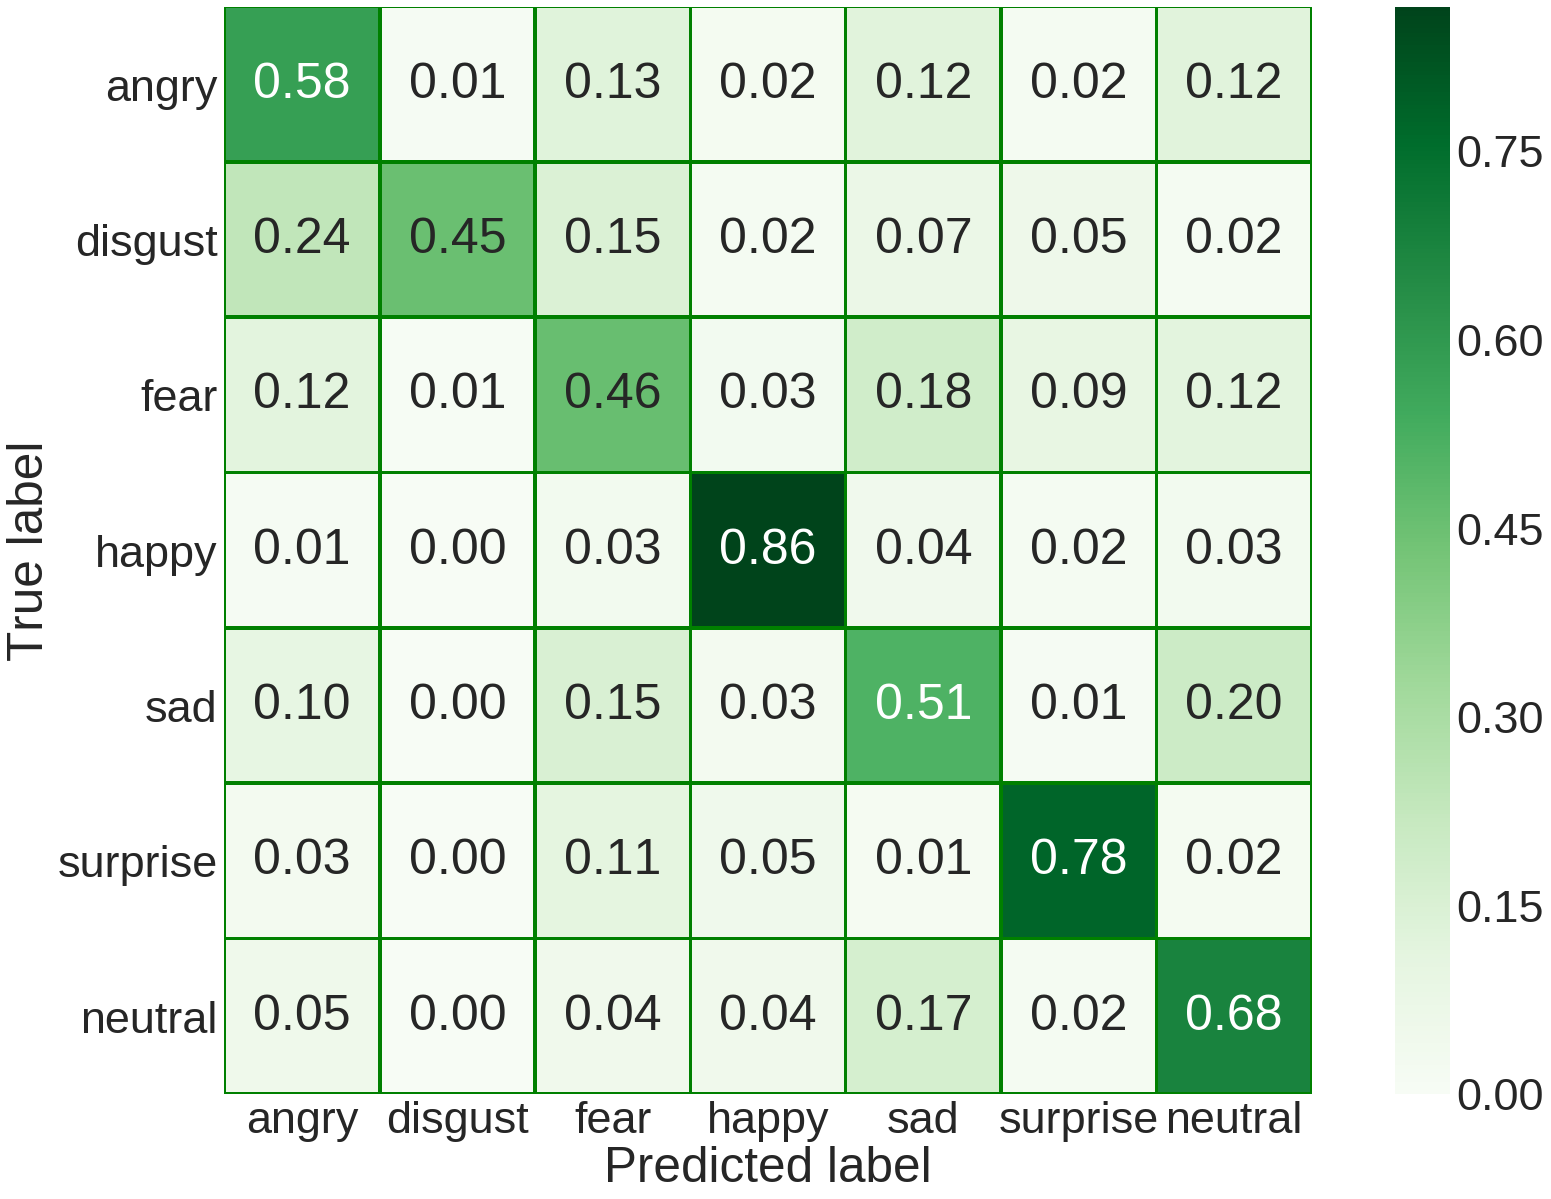

In [25]:
# Plot a confusion matrix
emotions_text = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

cm = confusion_matrix(y, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=4.5) 
fig, ax = plt.subplots(figsize=(30,20))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=2.5, square=True, linecolor="Green", 
                    cmap="Greens", yticklabels=emotions_text, xticklabels=emotions_text, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 50})
ax.set(xlabel='Predicted label', ylabel='True label')
# fig.savefig(MODEL_BASE_NAME + '_accuracy.png')